In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import data

In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ML project/Project 2.0/data.csv", sep= ";", usecols=[0,1,2,3,4], names=['canale','data','negozi','vendite','qta'], header=0, parse_dates=['data'], dayfirst = True)
df["data"] = pd.to_datetime(df["data"])
df = df.set_index('data')


can2 = df[df['canale'] == 2]
can2_raw = can2.vendite.values

## Preprocessing & Exploration

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
#log - per ridurre l'effetto di tendenza
can2_log_trans = np.log(can2_raw)

#difference transform

def difference(data, interval):
    return [data[i]-data[i-interval] for i in range(interval, len(data))]

can2_diff_trans = difference(can2_log_trans, 12)

#standardization
can2_new_diff = np.array(can2_diff_trans).reshape(len(can2_diff_trans),1)

In [5]:
from matplotlib import pyplot as plt

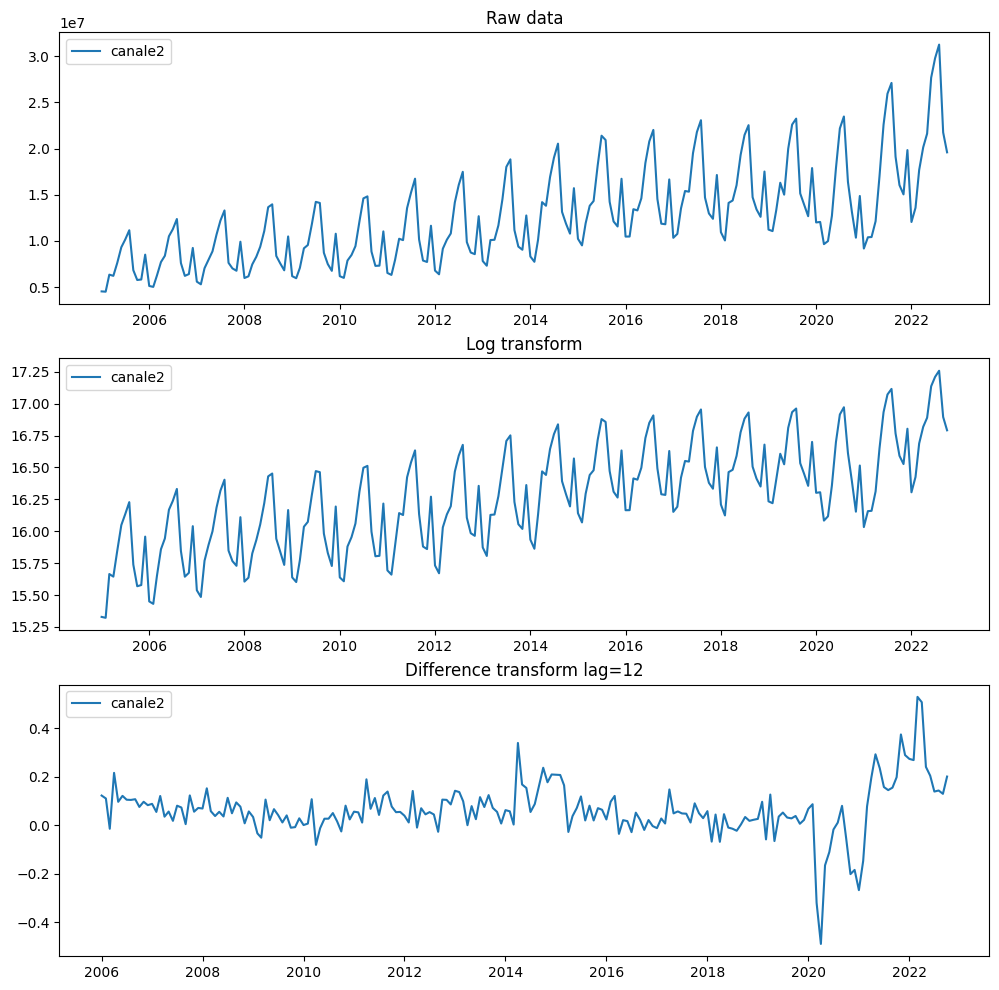

In [6]:
#plot raw data
fig, axs = plt.subplots(3,1,figsize=(12,12))

axs[0].plot(can2.index,can2_raw)
axs[0].set_title("Raw data")
axs[0].legend(['canale2'])

#plot log transform
axs[1].plot(can2.index, can2_log_trans)
axs[1].set_title('Log transform')
axs[1].legend(['canale2'])

#plot difference transform

axs[2].plot(can2.index[12:], can2_diff_trans)
axs[2].set_title('Difference transform lag=12')
axs[2].legend(['canale2'])

plt.show()

### STL

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
can2

,canale,negozi,vendite,qta
data,,,,
2005-01-01,2,10,4537268,3258491
2005-02-01,2,10,4505435,3290646
2005-03-01,2,10,6349726,4309582
2005-04-01,2,10,6222342,4486899
2005-05-01,2,10,7628105,5663967
...,...,...,...,...
2022-06-01,2,21,27675452,15771100
2022-07-01,2,21,29778601,17508509
2022-08-01,2,21,31253542,17099585


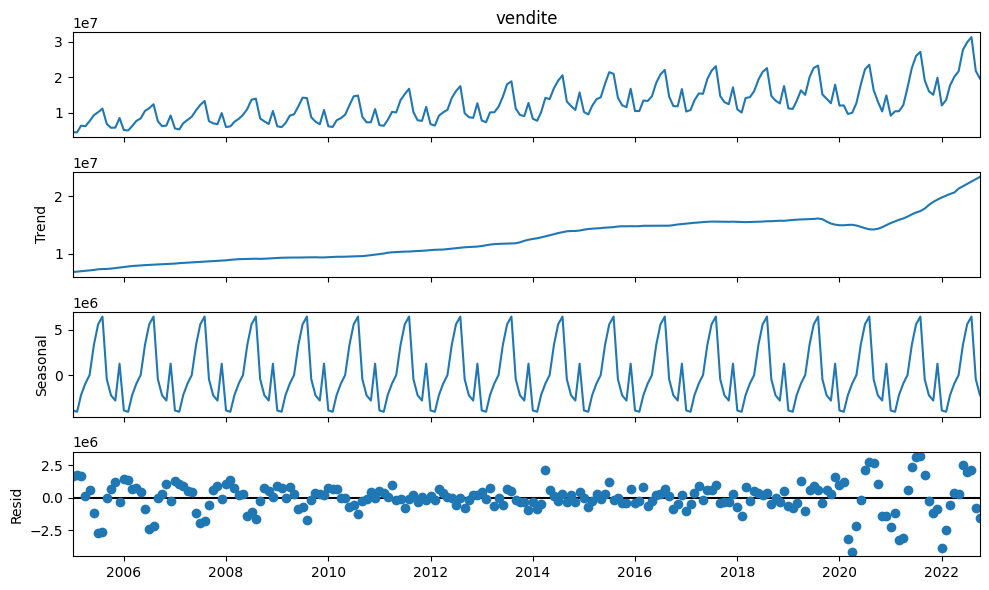

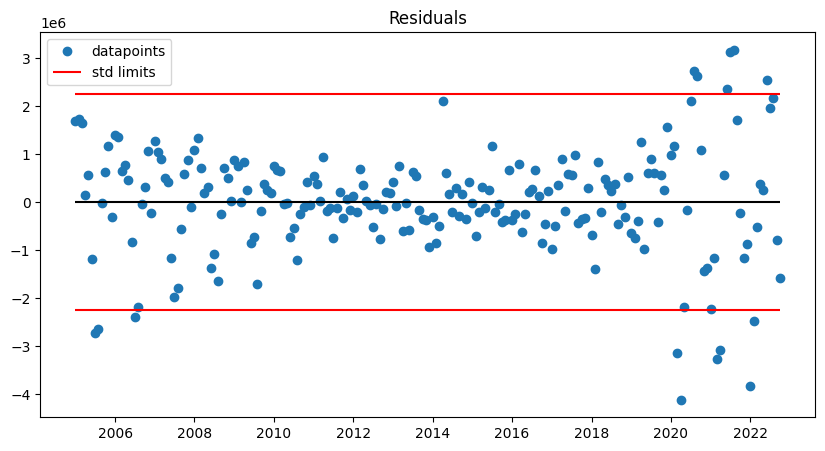

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
can2_stl = can2['vendite'] # converts to series

result = seasonal_decompose(can2_stl, model='additive',period=12, extrapolate_trend='freq')
result.plot()
plt.show()

observed = result.observed
trend = result.trend
seasonal = result.seasonal
resid = result.resid
std = resid.std()

plt.figure(figsize=(10, 5))
plt.plot(can2.index, resid, "o", label="datapoints")
plt.hlines(0, min(can2.index), max(can2.index), colors="k")
plt.hlines(2 * std, min(can2.index), max(can2.index), color="red", label="std limits")
plt.hlines(-2 * std, min(can2.index), max(can2.index), color="red")
plt.legend()
plt.title('Residuals')
plt.show()


### Regression of deseasoned data on "Number of Shops"

In [10]:
merged_df = pd.DataFrame()
merged_df['vendite'] = can2.vendite
merged_df['negozi'] = can2.negozi.values

merged_df['vendite_negozio'] = round(merged_df['vendite'] / merged_df['negozi'],0)
merged_df

,vendite,negozi,vendite_negozio
data,,,
2005-01-01,4537268,10,453727.0
2005-02-01,4505435,10,450544.0
2005-03-01,6349726,10,634973.0
2005-04-01,6222342,10,622234.0
2005-05-01,7628105,10,762810.0
...,...,...,...
2022-06-01,27675452,21,1317879.0
2022-07-01,29778601,21,1418029.0
2022-08-01,31253542,21,1488264.0


In [11]:
from sklearn import linear_model
from sklearn.metrics import r2_score

In [12]:
deseasoned = trend + resid
regr = linear_model.LinearRegression()

In [13]:
negozi = np.array(merged_df['negozi']).reshape(len(merged_df['negozi']),1)
regr.fit(negozi, deseasoned)
pred_y_neg = regr.predict(negozi)
r2_neg = r2_score(deseasoned, pred_y_neg)
print("R2 = {:.3f}".format(r2_neg))

R2 = 0.839


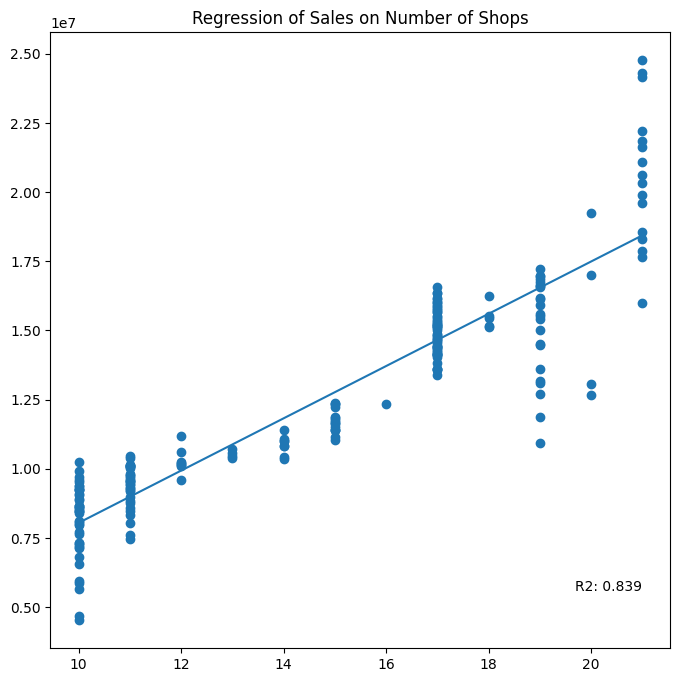

In [14]:
    #   subplot regressione su negozi
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
axs.scatter(negozi, deseasoned)
axs.plot(negozi, pred_y_neg)
axs.set_title('Regression of Sales on Number of Shops')
axs.text(0.9, 0.1, 'R2: {:.3f}'.format(r2_neg), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)
plt.show()

## Forecasting

### Baseline - ETS Holt Winters

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


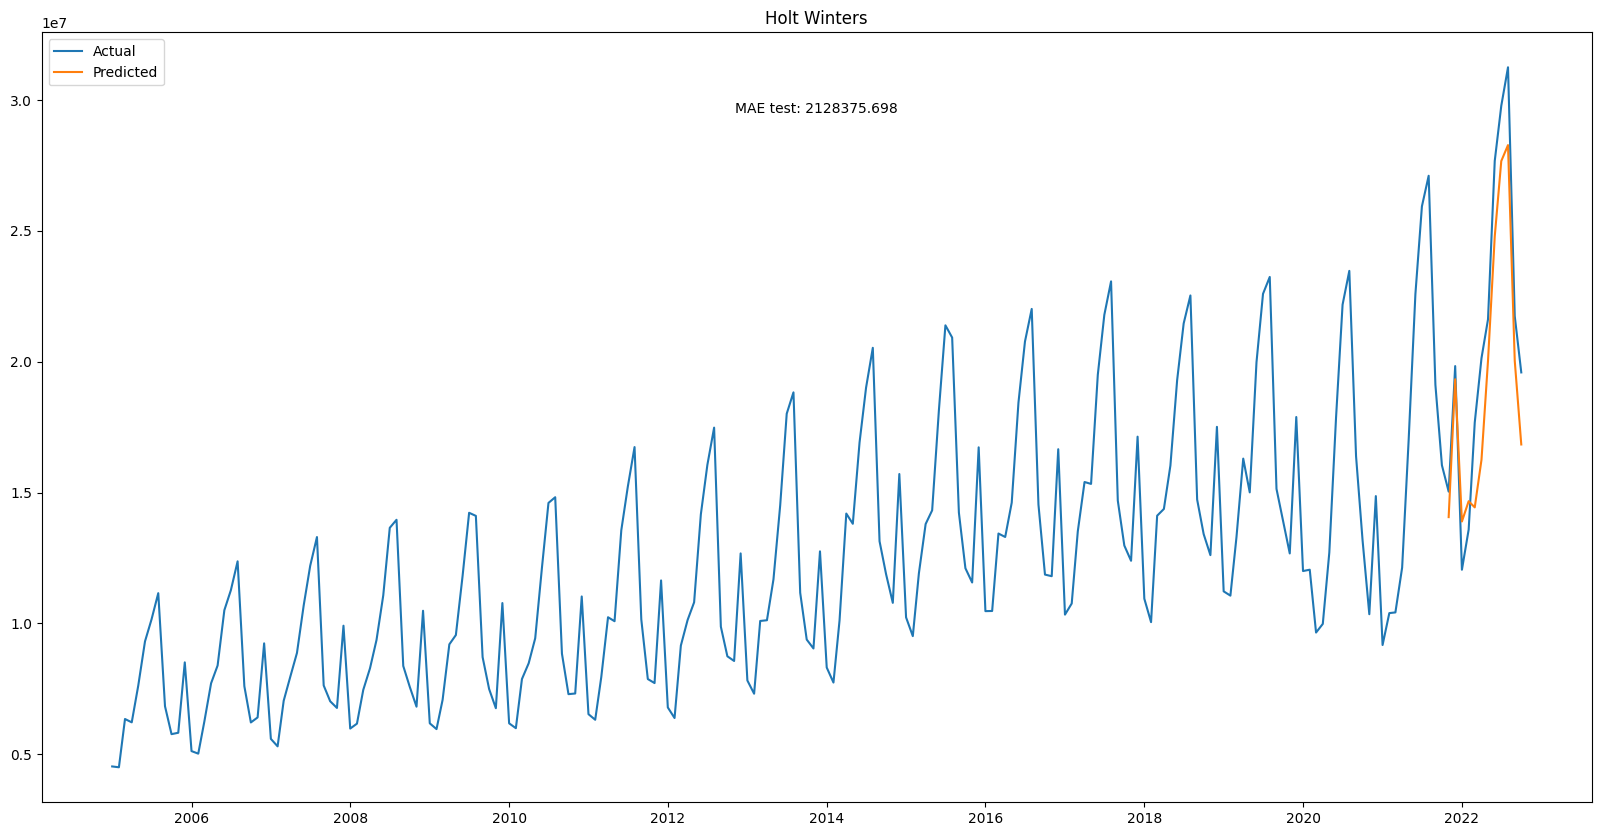

In [16]:
from keras.src.models.cloning import Model
# Holt_Winters Method Trend: additive, Seasonality: additive - STAGIONALITA' in considerazione

train = can2.vendite[:-12]
test = can2.vendite[-12:]

model = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=12 ,trend='add', seasonal='add',)
result = model.fit()

predictions = result.forecast(12)

mae_hwaa = mean_absolute_error(test, predictions)

#plot
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,10))

axs.plot(can2.vendite, label='Actual')
axs.plot(can2.index ,[None for i in train] + [x for x in predictions], label='Predicted')
axs.set_title("Holt Winters")
axs.legend()
axs.text(0.5, 0.9, 'MAE test: {:.3f}'.format(mae_hwaa), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)
plt.show()

### AutoARIMA

In [ ]:
#!pip install pmdarima

In [18]:
import pmdarima as pm

In [19]:
def autoarima(dataset, test_lenght=12):
    train = dataset.vendite[0:-test_lenght]
    test = dataset.vendite[-test_lenght:]

    model = pm.auto_arima(train, start_p=0, start_q=0,
            max_p=12, max_d=2, max_q=12, start_P=0, start_Q=0,
            max_P=1, max_D=1, max_Q=1, max_order=26, m=12,
            test='adf', seasonal=True, trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True) # stepwise=False full grid
    print(model.summary())
    morder = model.order # p,d,q
    mseasorder = model.seasonal_order # P,D,Q,m
    fitted = model.fit(train)
    yfore = fitted.predict(n_periods=test_lenght) # forecast
    ypred = fitted.predict_in_sample()
    mae = mean_absolute_error(test, yfore)

    return {'train': train,
            'test': test,
            'ypred': ypred,
            'yfore': yfore,
            'mae': mae, 'morder': morder,
            'mseasorder': mseasorder}

In [20]:
aa_raw = autoarima(merged_df)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5775.026, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5750.864, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5748.750, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5762.571, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5750.696, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5750.392, Time=0.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5757.710, Time=0.41 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5744.045, Time=1.60 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5763.573, Time=0.47 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5746.011, Time=2.61 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5745.989, Time=1.74 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5749.229, Time=0.51 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5745.085, Time=2.77 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=5745.461, Time=2.10 sec
 ARIMA(0,1,2)(0,1,1

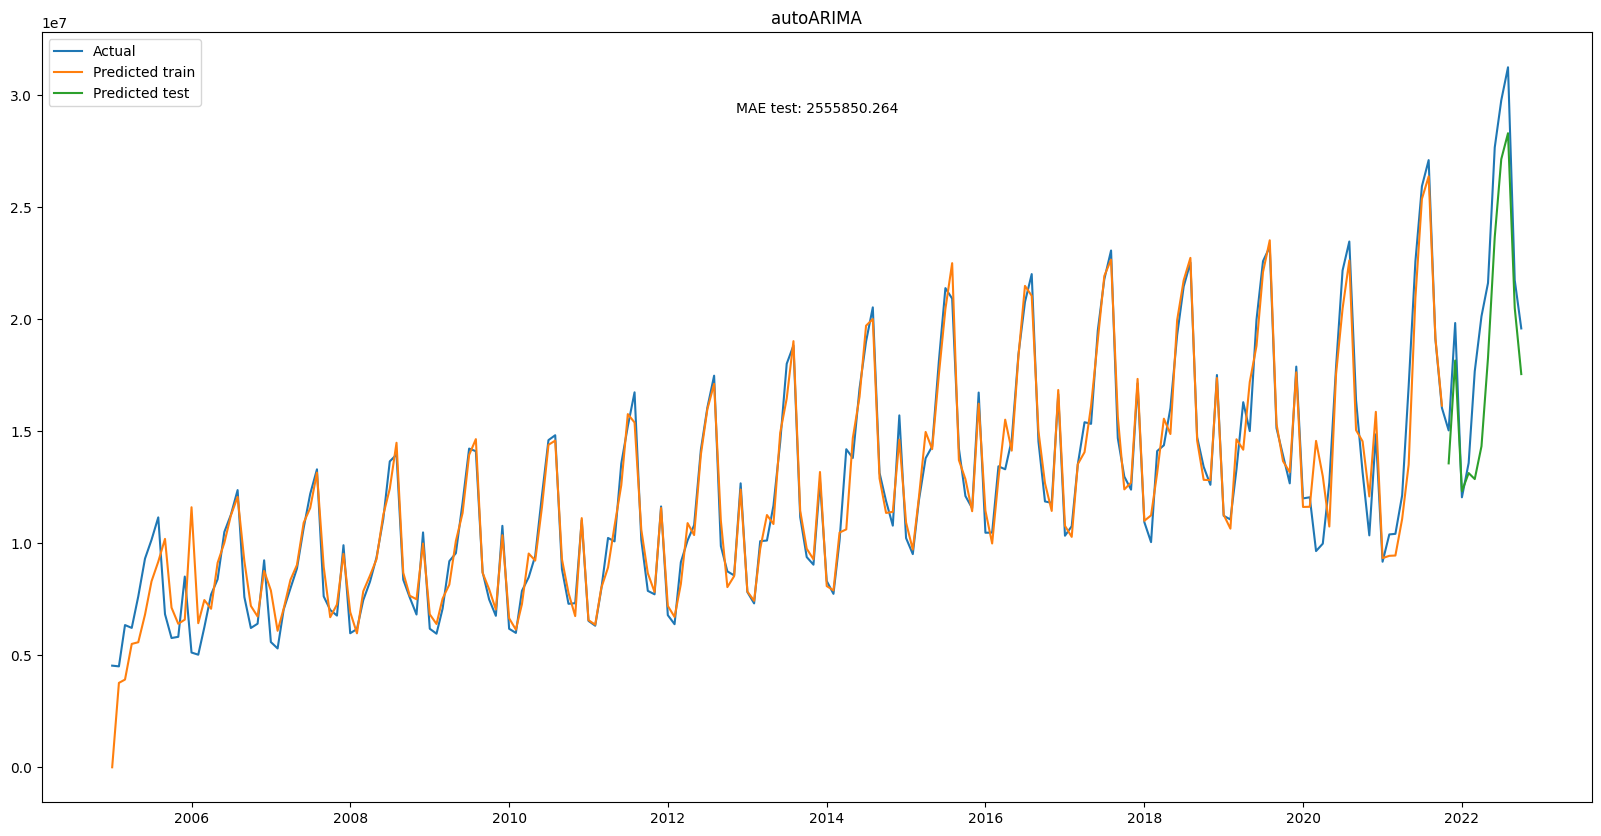

In [21]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
    #   subplot dati originali
axs.plot(merged_df.vendite, label='Actual')
axs.plot(aa_raw['ypred'], label='Predicted train')
axs.plot(merged_df.index ,[None for i in aa_raw['ypred']] + [x for x in aa_raw['yfore']], label='Predicted test')
axs.set_title("autoARIMA")
axs.legend()
axs.text(0.5, 0.9, 'MAE test: {:.3f}'.format(aa_raw['mae']), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)
plt.show()

### SARIMAX

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
def SARIMAXf(dataset, test_length=12, morder=(0,0,0), mseasorder=(0,0,0,0)):
    negozi = dataset.negozi
    negozi_train = negozi[0:-test_length]
    negozi_test = negozi[-test_length:]

    train = dataset.vendite[0:-test_length]
    test = dataset.vendite[-test_length:]

    model = SARIMAX(train, exog=negozi_train, order=morder, seasonal_order=mseasorder, freq ='MS')
    model_fit = model.fit(disp=False)

    yhat = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=negozi_test, freq = 'MS')

    mae = mean_absolute_error(test, yhat)

    return {'train': train,
            'test': test,
            'yhat': yhat,
            'mae': mae}

In [24]:
sarimax_raw = SARIMAXf(merged_df, morder = aa_raw['morder'], mseasorder = aa_raw['mseasorder'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['freq']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


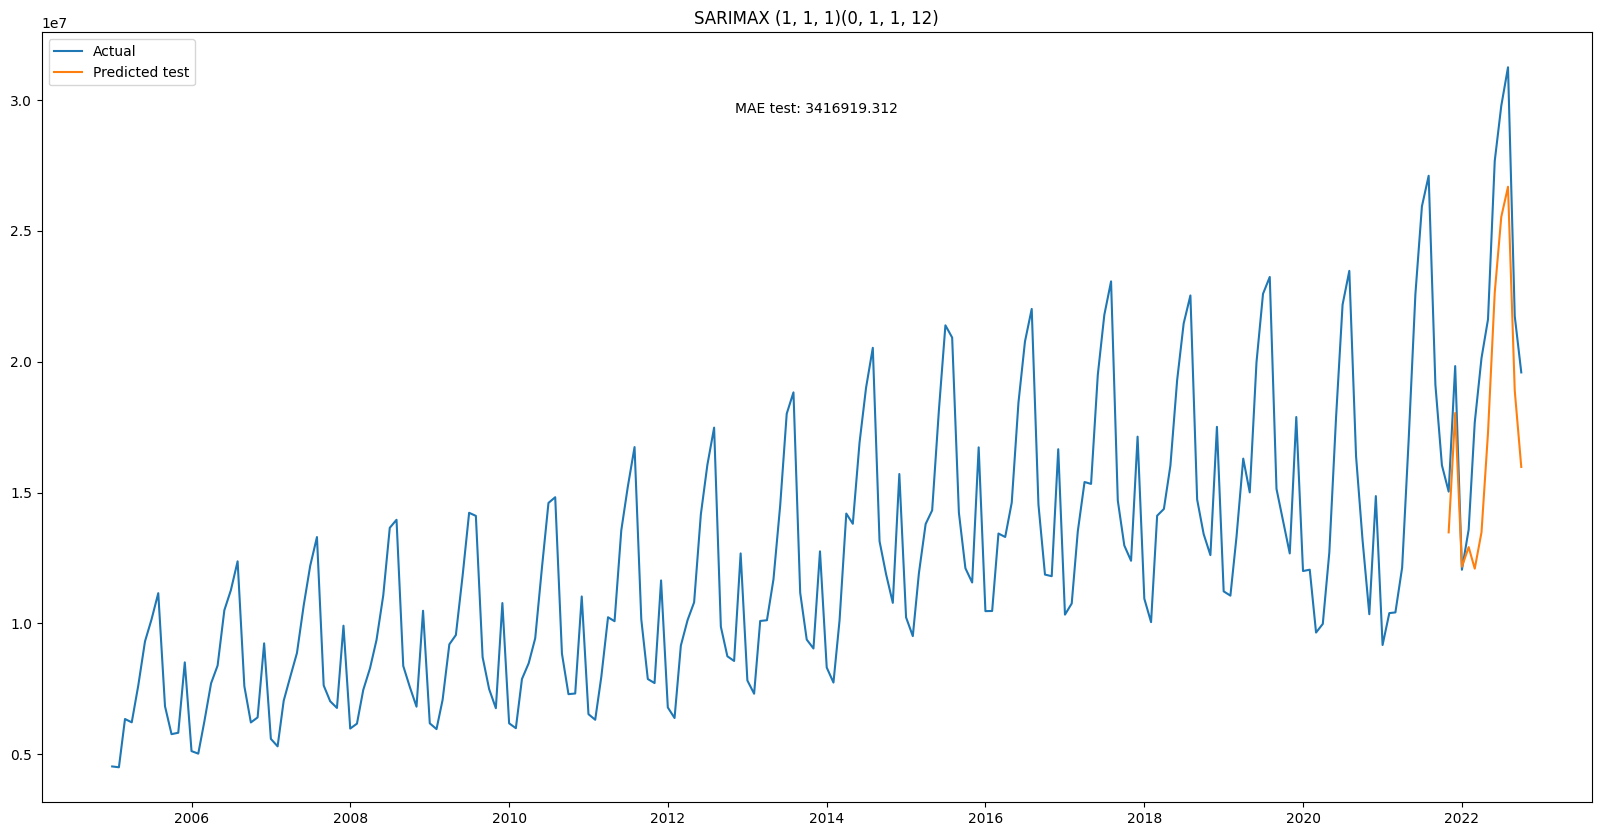

In [25]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
axs.plot(merged_df.vendite, label='Actual')
axs.plot(merged_df.index ,[None for i in sarimax_raw['train']] + [x for x in sarimax_raw['yhat']], label='Predicted test')
axs.set_title("SARIMAX {}{}".format(aa_raw['morder'], aa_raw['mseasorder']))
axs.legend()
axs.text(0.5, 0.9, 'MAE test: {:.3f}'.format(sarimax_raw['mae']), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)

plt.show()

### XGBoost

In [26]:
from xgboost import XGBRegressor

In [27]:
def XGB(can2_ml, length_test=12):
    # Rolling window dataset
    lookback = 12
    dataset = pd.DataFrame()
    for i in range(lookback, 0, -1):
        dataset['t-' + str(i)] = can2_ml['vendite'].shift(i)
    dataset['t'] = can2_ml['vendite'].values
    dataset['negozi'] = can2_ml['negozi'].values
    dataset = dataset[lookback:]

    # Splitting data
    x = dataset[['t-' + str(i) for i in range(lookback, 0, -1)] + ['negozi']]
    y = dataset['t']
    x_train, x_test = x[:-length_test], x[-length_test:]
    y_train, y_test = y[:-length_test], y[-length_test:]

    # Fit model
    XGB_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    XGB_model.fit(x_train, y_train)

    # Make a one-step prediction
    yhat = XGB_model.predict(x_test)
    mae = int(mean_absolute_error(y_test, yhat))

    return {'y_train':y_train, 'y_test':y_test, 'yhat':yhat,'mae':mae}


In [28]:
XGB_real = XGB(can2[['negozi', 'vendite']])


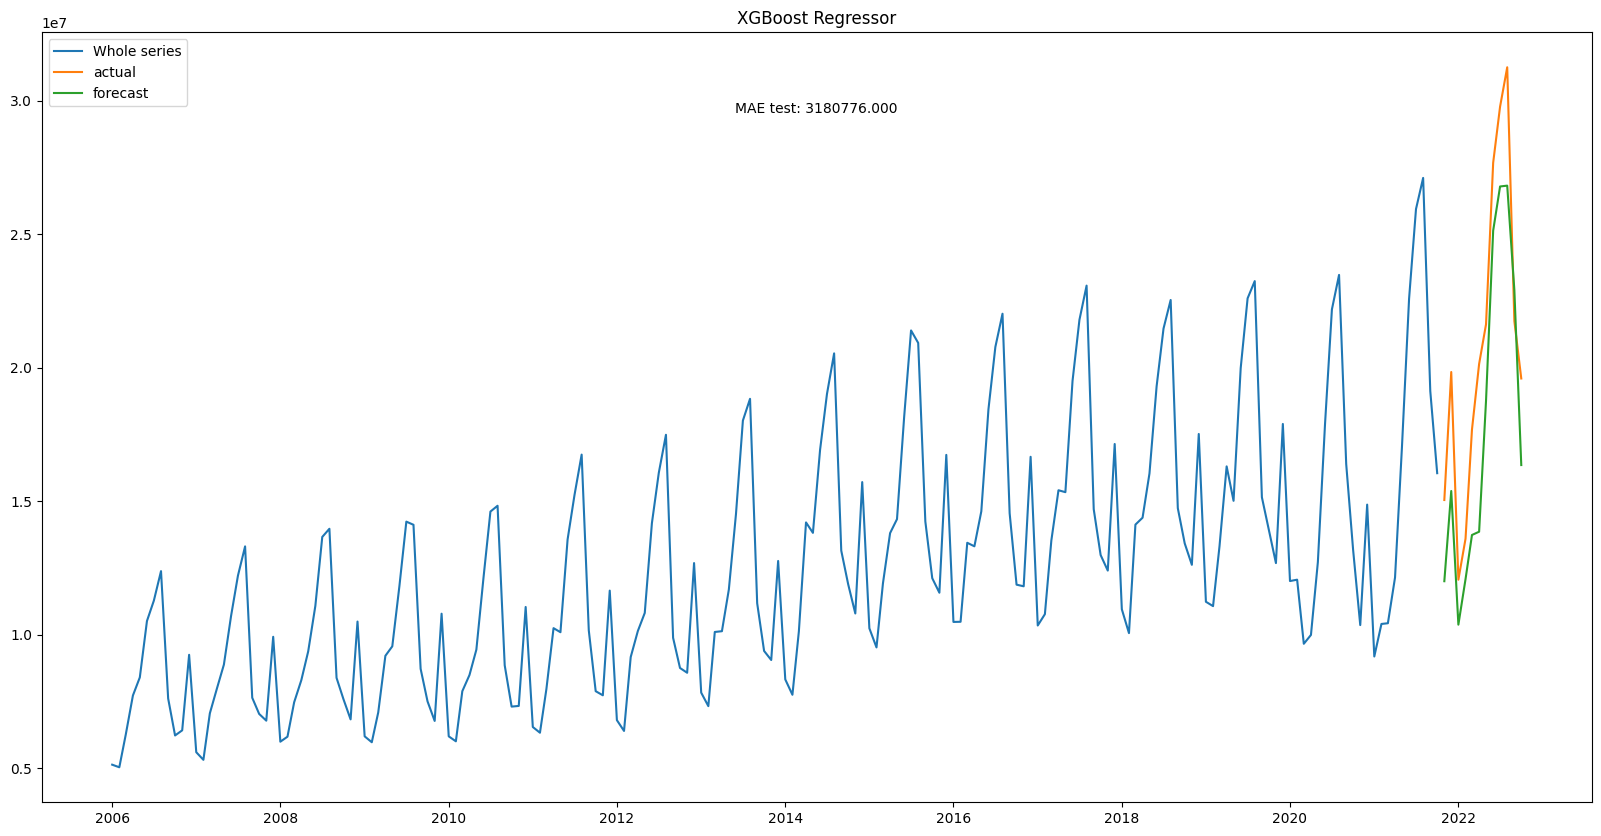

In [29]:
#plotting
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.set_title('XGBoost Regressor')
axs.plot(XGB_real['y_train'], label="Whole series")
axs.plot(XGB_real['y_test'], label="actual")
axs.plot(df.index[-12:],XGB_real['yhat'], label="forecast")
axs.text(0.5, 0.9, 'MAE test: {:.3f}'.format(XGB_real['mae']), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)
axs.legend()

plt.show()

### MLP

In [30]:
from keras.models import Sequential
from keras.layers import Dense

In [31]:
def create_dataset(dataset, num_shops, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i : (i + look_back), 0]
        b = num_shops[i : ( i + look_back),0]
        dataX.append(np.concatenate((a, b)))
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
def mlp(dataset, length_test=12):
    num_shops = can2.negozi.values  # number of shops
    dataset = dataset.astype('float32')  # needed for MLP input
    num_shops = num_shops.astype('float32')
    dataset = dataset.reshape(dataset.shape[0], 1)
    num_shops = num_shops.reshape(num_shops.shape[0], 1)

    # train and test set
    train = dataset[:-length_test]
    num_shops_train = num_shops[:-length_test]
    test = dataset[-length_test:]
    num_shops_test = num_shops[-length_test:]

    look_back = 12
    testdata = np.concatenate((train[-look_back:], test))
    num_shops_testdata = np.concatenate((num_shops_train[-look_back:], num_shops_test))
    trainX, trainY = create_dataset(train, num_shops_train, look_back)
    testX, testY = create_dataset(testdata, num_shops_testdata, look_back)

    loss_function = 'mean_absolute_error'
    model = Sequential()
    model.add(Dense(length_test*2+1, input_dim=trainX.shape[1], activation='relu'))  #Lippmann hidden neurons: 2n+1
    model.add(Dense(1))  # 1 output neuron
    model.compile(loss=loss_function, optimizer='adam')
    model.fit(trainX, trainY, epochs=500, batch_size=2, verbose=2)

     # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    testScore = model.evaluate(testX, testY, verbose=0)
    # generate predictions for training and forecast for plotting
    trainPredict = model.predict(trainX)

    # Initialize the forecast array with the predicted training values
    forecast = trainPredict[:, 0]

    for i in range(len(testX)):
        forecast_input = np.concatenate((forecast[-look_back:], num_shops_testdata[i:i+look_back]), axis=None).reshape(1, look_back * 2)
        testForecast = model.predict(forecast_input)
        forecast = np.append(forecast, testForecast)
    return {'trainX':trainX, 'trainY':trainY, 'testX':testX, 'testY':testY, 'trainPredict': trainPredict, 'forecast':forecast, 'testScore': testScore}



In [41]:
mlp_real = mlp(can2.vendite.values)

Epoch 1/500
95/95 - 1s - loss: 4189158.7500 - 961ms/epoch - 10ms/step
Epoch 2/500
95/95 - 0s - loss: 1893012.5000 - 215ms/epoch - 2ms/step
Epoch 3/500
95/95 - 0s - loss: 1560903.7500 - 207ms/epoch - 2ms/step
Epoch 4/500
95/95 - 0s - loss: 1311066.5000 - 234ms/epoch - 2ms/step
Epoch 5/500
95/95 - 0s - loss: 1148768.6250 - 215ms/epoch - 2ms/step
Epoch 6/500
95/95 - 0s - loss: 1027700.8125 - 232ms/epoch - 2ms/step
Epoch 7/500
95/95 - 0s - loss: 960286.6250 - 230ms/epoch - 2ms/step
Epoch 8/500
95/95 - 0s - loss: 971980.5625 - 215ms/epoch - 2ms/step
Epoch 9/500
95/95 - 0s - loss: 962222.0625 - 201ms/epoch - 2ms/step
Epoch 10/500
95/95 - 0s - loss: 880239.5625 - 222ms/epoch - 2ms/step
Epoch 11/500
95/95 - 0s - loss: 964883.3750 - 202ms/epoch - 2ms/step
Epoch 12/500
95/95 - 0s - loss: 881176.1875 - 211ms/epoch - 2ms/step
Epoch 13/500
95/95 - 0s - loss: 843237.8750 - 214ms/epoch - 2ms/step
Epoch 14/500
95/95 - 0s - loss: 849291.8125 - 221ms/epoch - 2ms/step
Epoch 15/500
95/95 - 0s - loss: 8794

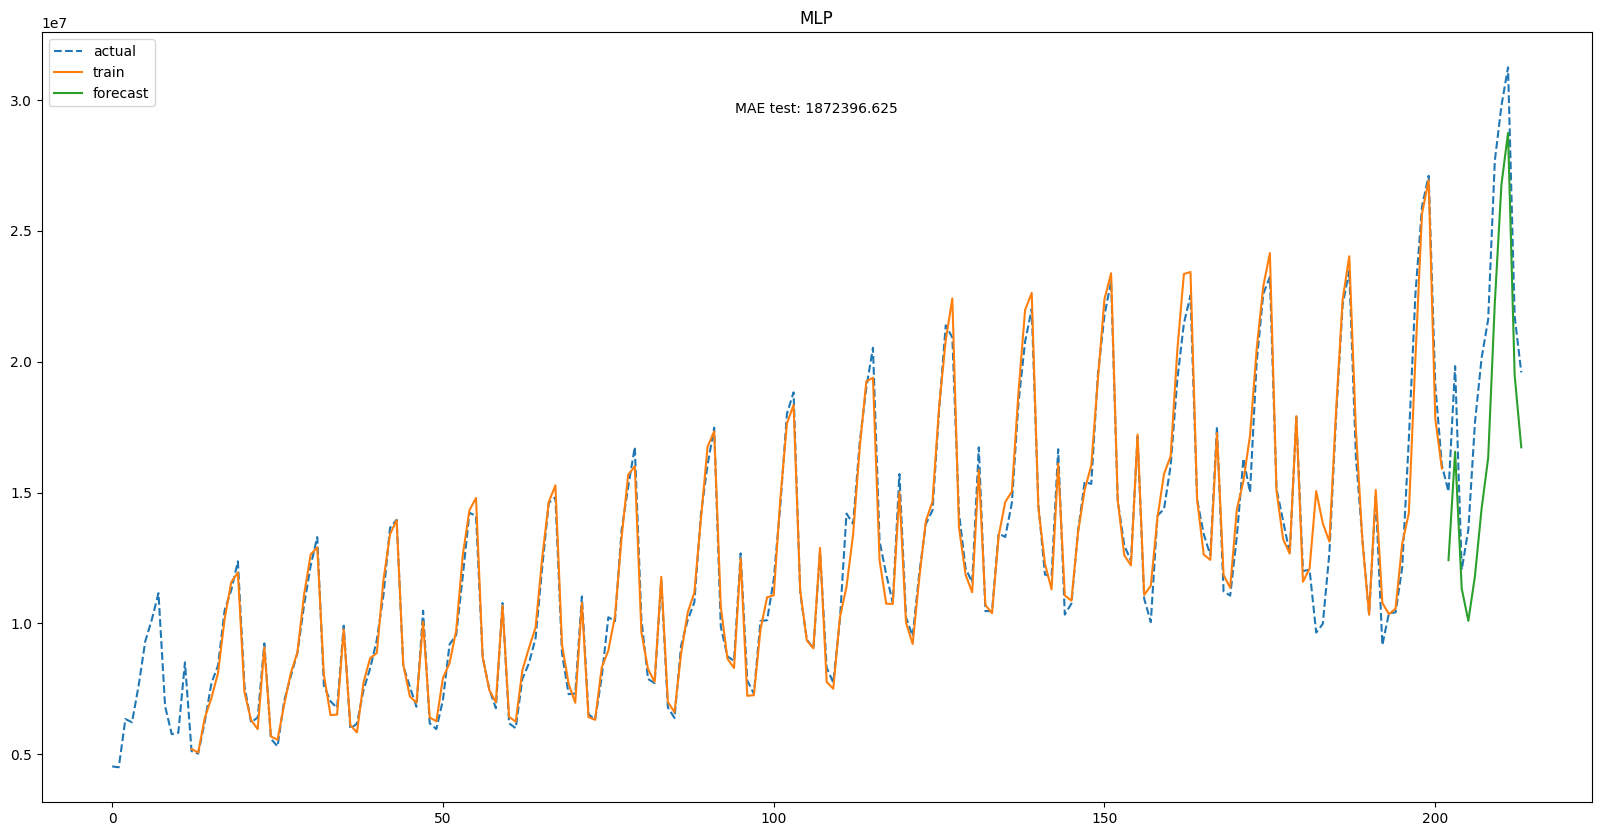

In [42]:
#plotting
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.set_title('MLP')
axs.plot(can2.vendite.values, '--', label="actual")
axs.plot(np.concatenate((np.full((12,1), np.nan), mlp_real['trainPredict'])),  label = "train")
axs.plot(np.concatenate((np.full(len(mlp_real['trainX'])+12, np.nan), mlp_real['forecast'][-12:])),  label = "forecast")
axs.text(0.5, 0.9, 'MAE test: {:.3f}'.format(mlp_real['testScore']), horizontalalignment='center', verticalalignment='center', transform=axs.transAxes)
axs.legend()

plt.show()

## Results comparison

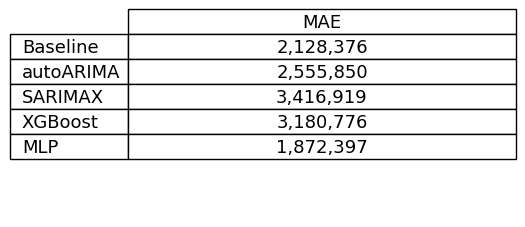

In [43]:
#Confronto MAE
maes = pd.DataFrame({
    'Baseline': [mae_hwaa],
    'autoARIMA': [aa_raw['mae']],
    'SARIMAX': [sarimax_raw['mae']],
    'XGBoost': [XGB_real['mae']],
    'MLP': [mlp_real['testScore']]
})

maes = maes.applymap(lambda x: '{:,.0f}'.format(x))
maes = maes.transpose()  # Trasponi la tabella
maes.columns = ['MAE']  # Rinomina la colonna delle valori
maes.index.name = 'Model'  # Imposta il nome dell'indice delle righe


fig, ax = plt.subplots(figsize=(5, 0.75))
ax.axis('off')
table = ax.table(cellText=maes.values,rowLabels= maes.index, colLabels=maes.columns, cellLoc='center', loc='top')
table.set_fontsize(13)
table.scale(1, 1.5)
plt.show()

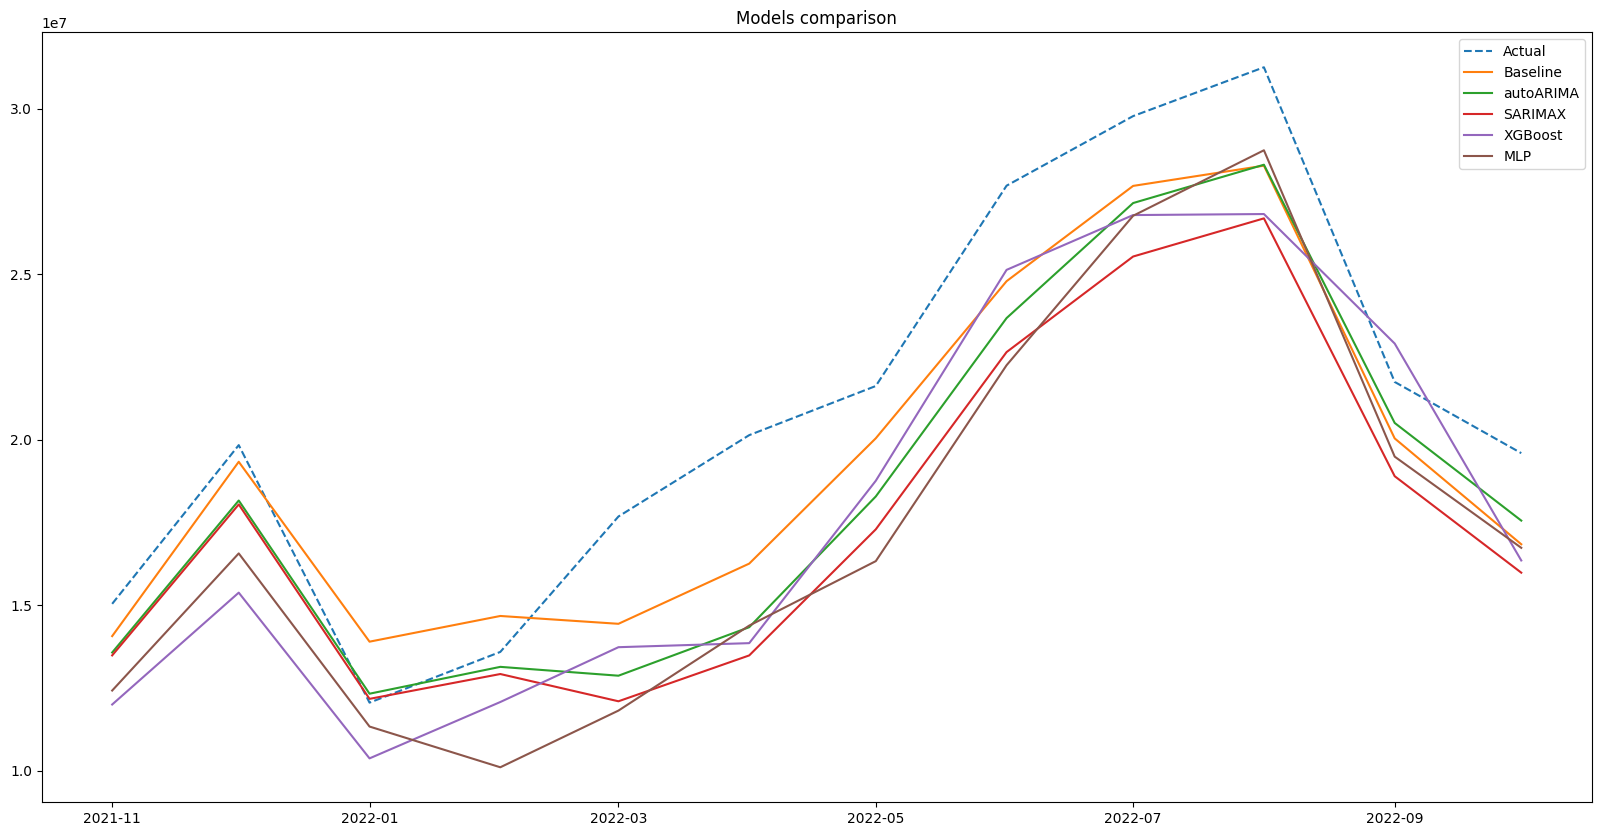

In [44]:
#plotting all the models
fig, axs = plt.subplots(1,1,figsize=(20,10))
axs.set_title('Models comparison')
axs.plot(can2.index[-12:], can2.vendite.values[-12:], '--', label="Actual")
axs.plot(can2.index[-12:], predictions,  label = "Baseline")
axs.plot(can2.index[-12:], aa_raw['yfore'],  label = "autoARIMA")
axs.plot(can2.index[-12:], sarimax_raw['yhat'],  label = "SARIMAX")
axs.plot(can2.index[-12:], XGB_real['yhat'],  label = "XGBoost")
axs.plot(can2.index[-12:], mlp_real['forecast'][-12:],  label = "MLP")
axs.legend()

plt.show()

In [45]:
mean_test_values = np.mean(can2.vendite.values[-12:])

print("The mean sales value for the test data is: {:,.0f}".format(mean_test_values))

The mean sales value for the test data is: 20,833,356
